Take home message
* T5 has to be loaded an used in bfloat16, not float16!!
    * During training and eval through training, we used bfloat16 embdding. 
* We trained float16 version. 

In [1]:
#%%
# %load_ext autoreload
# %autoreload 2
#%%
import os
from os.path import join
import torch
import torch as th
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm.auto import trange
from contextlib import redirect_stdout

import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
from transformers import T5Tokenizer, T5EncoderModel

sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom
from utils.pixart_utils import state_dict_convert
from utils.text_encoder_control_lib import RandomEmbeddingEncoder_wPosEmb
from utils.image_utils import pil_images_to_grid
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
from utils.cv2_eval_utils import find_classify_object_masks
from utils.attention_analysis_lib import plot_attention_layer_head_heatmaps, plot_layer_head_score_summary
from utils.attention_analysis_lib import *
from utils.cv2_eval_utils import find_classify_object_masks
from utils.obj_mask_utils import *
from circuit_toolkit.plot_utils import saveallforms

MAXIMUM = 255
# Create multi-hot masks for each category
def create_multi_hot_token_mask(tokens, target_words, seq_len=None):
    mask = th.zeros(len(tokens) if seq_len is None else seq_len, dtype=th.bool)
    for i, token in enumerate(tokens):
        # Remove the special prefix if present
        clean_token = token.replace('▁', '') if token.startswith('▁') else token
        if clean_token in target_words:
            mask[i] = True
    return mask


def create_object_based_masks(image_list, get_mask_func, map_shape=(8, 8), positive_threshold=180,):
    """
    some mask functions:
    - get_square_pos_others_neg_mask
    - get_triangle_pos_others_neg_mask
    - get_circle_pos_others_neg_mask
    - get_square_pos_others_neg_mask
    - get_triangle_pos_others_neg_mask
    - get_circle_pos_others_neg_mask
    """
    img_msks = []
    for img_idx in range(len(image_list)):
        image = image_list[img_idx]
        df, object_masks = find_classify_object_masks(image)
        obj_masks_resized = [cv2.resize(obj_mask, map_shape, interpolation=cv2.INTER_CUBIC) for obj_mask in object_masks]
        obj_masks_resized_binary = [obj_mask > positive_threshold for obj_mask in obj_masks_resized]
        obj_masks_resized_float = [obj_mask.astype(float) / MAXIMUM for obj_mask in obj_masks_resized]
        img_square_msk, _ = get_mask_func(df, obj_masks_resized_float)
        # img_triangle_msk, _ = get_triangle_pos_others_neg_mask(df, obj_masks_resized_float)
        # img_circle_msk, _ = get_circle_pos_others_neg_mask(df, obj_masks_resized_float)
        img_msks.append(th.from_numpy(img_square_msk).float())
    img_msks = th.stack(img_msks)
    # img_msks.shape # (n_samples, H, W)
    cmb_img_msks = img_msks.repeat(2,1,1)
    cmb_img_msks = cmb_img_msks.unsqueeze(1)
    # cmb_img_msks.shape # (n_samples * 2, 1, H, W)
    cmb_img_msks_vec = cmb_img_msks.flatten(start_dim=-2)
    return cmb_img_msks_vec, img_msks


def print_top_k_scores(scores, k=10, title="Top scores"):
    """
    Print the top k scores and their layer/head indices.
    
    Args:
        scores: tensor of shape (n_layers, n_heads, ...)
        k: number of top scores to print
        title: title for the output
    """
    # Flatten the scores while keeping track of layer and head indices
    scores = th.from_numpy(scores)
    n_layers, n_heads = scores.shape[:2]
    flattened_scores = scores.flatten()
    # Get the top k scores and their indices
    top_k_values, top_k_indices = flattened_scores.topk(k, largest=True)
    print(f"\n{title}:")
    print("-" * 50)
    for i, (value, idx) in enumerate(zip(top_k_values, top_k_indices)):
        # Convert flat index back to layer, head, and remaining dimensions
        remaining_size = scores.numel() // (n_layers * n_heads)
        layer_head_idx = idx // remaining_size
        layer_idx, head_idx = divmod(layer_head_idx.item(), n_heads)
        print(f"Top{i+1}: L{layer_idx}H{head_idx}, Score: {value:.2f}")
        
        
def test_product_prompt_list():
    from itertools import product
    colors = ['red', 'blue']
    target_shapes = ['square', 'triangle', 'circle']
    verticals = ['above', 'below']
    horizontals = ['to the left of', 'to the right of']
    prompts = []
    for c1, c2 in product(colors, colors):
        if c1 == c2:      # skip same‐color pairs
            continue
        for shape1, shape2 in product(target_shapes, target_shapes):
            if shape1 == shape2:
                continue
            for v, h in product(verticals, horizontals):
                prompts.append(f"{c1} {shape1} is {v} and {h} the {c2} {shape2}")
    return prompts


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Pleas

In [ ]:
# import argparse

# def parse_args():
#     parser = argparse.ArgumentParser(description='Cross attention head filtering for multiple models')
#     parser.add_argument('--model_run_name', type=str, required=True,
#                         help='Name of the model run (e.g., objrel_T5_DiT_B_pilot)')
#     parser.add_argument('--ckpt_name', type=str, required=True,
#                         help='Checkpoint name (e.g., epoch_4000_step_160000.pth)')
#     parser.add_argument('--text_encoder_type', type=str, required=True,
#                         choices=['T5', 'RandomEmbeddingEncoder_wPosEmb'],
#                         help='Type of text encoder to use')
#     parser.add_argument('--suffix', type=str, default='',
#                         help='Suffix for output directory naming')
#     return parser.parse_args()

# #%%
# args = parse_args()
# model_run_name = args.model_run_name
# ckpt_name = args.ckpt_name
# text_encoder_type = args.text_encoder_type
# suffix = args.suffix

### The functional T5 mini without WDecay

In [2]:
model_run_name = "objrel_T5_DiT_mini_pilot" # "objrel_rndembdposemb_DiT_B_pilot" 
# model_run_name = "objrel_T5_DiT_mini_pilot_WDecay" # "objrel_rndembdposemb_DiT_B_pilot" 
ckpt_name = "epoch_4000_step_160000.pth" # "epoch_4000_step_160000.pth" 
text_encoder_type = "T5" 
suffix = ""

In [5]:

text_feat_dir_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndemb/caption_feature_wmask'
T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")
if text_encoder_type == "T5":
    text_encoder = T5EncoderModel.from_pretrained(T5_path, load_in_8bit=False, torch_dtype=torch.float16, )
elif text_encoder_type == "RandomEmbeddingEncoder_wPosEmb":
    emb_data = th.load(join(text_feat_dir_old, "word_embedding_dict.pt"))
    text_encoder = RandomEmbeddingEncoder_wPosEmb(emb_data["embedding_dict"], 
                                                emb_data["input_ids2dict_ids"], 
                                                emb_data["dict_ids2input_ids"], 
                                                max_seq_len=20, embed_dim=4096,
                                                wpe_scale=1/6).to("cuda")
torch.cuda.empty_cache()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:

savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}/cross_attn_vis_figs"
os.makedirs(figdir, exist_ok=True)

config = read_config(join(savedir, 'config.py'))
weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()
num_layers = len(model.blocks)
transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=tokenizer,
    text_encoder=None,
    torch_dtype=weight_dtype,
)
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
# pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
pipeline.tokenizer = tokenizer
pipeline.text_encoder = text_encoder
pipeline.to(device="cuda", dtype=weight_dtype);

# add attention map store hooks
pipeline.transformer = replace_attn_processor(pipeline.transformer)
attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
attnvis_store.setup_hooks()
torch.cuda.empty_cache()

2025-07-18 13:23:13,239 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.
/tmp/ipykernel_1327237/3032904557.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have ful

Setting up hooks for PixArt attention modules:
- Block 0
- Block 1
- Block 2
- Block 3
- Block 4
- Block 5


/tmp/ipykernel_1327237/2651134274.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, ckpt_name))


<All keys matched successfully>

### Compare EMA and Original

torch.Size([18, 20, 4096])
torch.Size([18, 20])


/tmp/ipykernel_1327237/797015539.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, ckpt_name))


  0%|          | 0/14 [00:00<?, ?it/s]

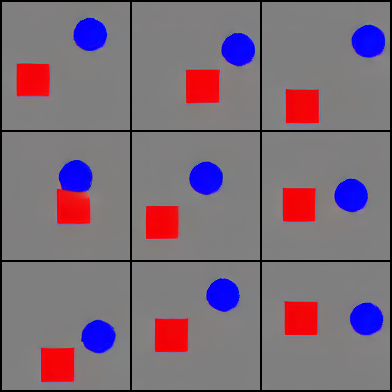

In [14]:
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))
prompt = "blue circle is above and to the right of the red square"
n_samples = 9
attnvis_store.clear_activation()
output = pipeline(prompt, 
        num_inference_steps=14,
            max_sequence_length=20, 
            num_images_per_prompt=n_samples,
            return_sample_pred_traj=True,
            device="cuda")
pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
grid = pil_images_to_grid(output[0].images)
grid

torch.Size([18, 20, 4096])
torch.Size([18, 20])


/tmp/ipykernel_1327237/3860547354.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, ckpt_name))


  0%|          | 0/14 [00:00<?, ?it/s]

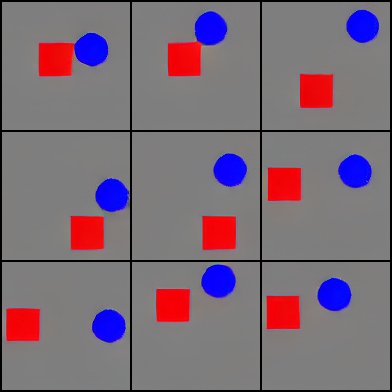

In [15]:
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
prompt = "blue circle is above and to the right of the red square"
n_samples = 9
attnvis_store.clear_activation()
output = pipeline(prompt, 
        num_inference_steps=14,
            max_sequence_length=20, 
            num_images_per_prompt=n_samples,
            return_sample_pred_traj=True,
            device="cuda")
pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
grid = pil_images_to_grid(output[0].images)
grid

### T5 WDecay

In [2]:
# model_run_name = "objrel_T5_DiT_mini_pilot" # "objrel_rndembdposemb_DiT_B_pilot" 
model_run_name = "objrel_T5_DiT_mini_pilot_WDecay" # "objrel_rndembdposemb_DiT_B_pilot" 
ckpt_name = "epoch_4000_step_160000.pth"  # "epoch_1500_step_60000.pth" # 
text_encoder_type = "T5" 
suffix = ""

In [7]:
from diffusers import PixArtTransformer2DModel
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}/cross_attn_vis_figs"
os.makedirs(figdir, exist_ok=True)

config = read_config(join(savedir, 'config.py'))
weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()
num_layers = len(model.blocks)
transformer = PixArtTransformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=tokenizer,
    text_encoder=None,
    torch_dtype=weight_dtype,
)
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
# pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
pipeline.tokenizer = tokenizer
pipeline.text_encoder = text_encoder
pipeline.to(device="cuda", dtype=weight_dtype);

# add attention map store hooks
pipeline.transformer = replace_attn_processor(pipeline.transformer)
attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
attnvis_store.setup_hooks()
torch.cuda.empty_cache()

2025-07-18 14:14:14,146 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_1337748/4065550627.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, ckpt_name))


Setting up hooks for PixArt attention modules:
- Block 0
- Block 1
- Block 2
- Block 3
- Block 4
- Block 5


torch.Size([18, 20, 4096])
torch.Size([18, 20])


/tmp/ipykernel_1337748/3996493150.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, ckpt_name))


  0%|          | 0/14 [00:00<?, ?it/s]

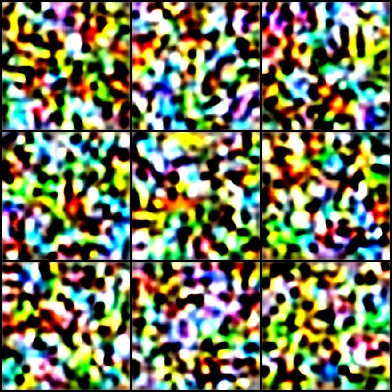

In [9]:
ckpt_name = "epoch_4000_step_160000.pth"
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
prompt = "blue circle is above and to the right of the red square"

n_samples = 9
attnvis_store.clear_activation()
output = pipeline(prompt, 
        num_inference_steps=14,
            max_sequence_length=20, 
            num_images_per_prompt=n_samples,
            return_sample_pred_traj=True,
            device="cuda")
pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
grid = pil_images_to_grid(output[0].images)
grid

### Reproducing the visualization pipeline from training

In [3]:
def visualize_prompts(pipeline, validation_prompts, prompt_cache_dir, max_length=120, weight_dtype=torch.float16,
                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, device="cuda"):
    # logger.info("Running validation... ")
    # device = accelerator.device
    # model = accelerator.unwrap_model(model)
    if validation_prompts is None:
        validation_prompts = [
            "triangle is to the upper left of square", 
            "blue triangle is to the upper left of red square", 
            "triangle is above and to the right of square", 
            "blue circle is above and to the right of blue square", 
            "triangle is to the left of square", 
            "triangle is to the left of triangle", 
            "circle is below red square",
            "red circle is to the left of blue square",
            "blue square is to the right of red circle",
            "red circle is above square",
            "triangle is above red circle",
            "red is above blue",
            "red is to the left of red",
            "blue triangle is above red triangle", 
            "blue circle is above blue square", 
        ]
    pipeline = pipeline.to(device)
    pipeline.set_progress_bar_config(disable=True)
    generator = torch.Generator(device=device).manual_seed(0)
    image_logs = []
    images = []
    latents = []
    uncond_data = torch.load(f'{prompt_cache_dir}/uncond_{max_length}token.pth', map_location='cpu')
    uncond_prompt_embeds = uncond_data['caption_embeds'].to(device)
    uncond_prompt_attention_mask = uncond_data['emb_mask'].to(device)
    visualized_prompts = []
    for _, prompt in enumerate(validation_prompts):
        if not os.path.exists(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth'):
            continue
        embed = torch.load(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth', map_location='cpu')
        caption_embs, emb_masks = embed['caption_embeds'].to(device), embed['emb_mask'].to(device)
        latents.append(pipeline(
            num_inference_steps=num_inference_steps,
            num_images_per_prompt=num_images_per_prompt,
            generator=generator,
            guidance_scale=guidance_scale,
            prompt_embeds=caption_embs,
            prompt_attention_mask=emb_masks,
            negative_prompt=None,
            negative_prompt_embeds=uncond_prompt_embeds,
            negative_prompt_attention_mask=uncond_prompt_attention_mask,
            use_resolution_binning=False, # need this for smaller images like ours. 
            output_type="latent",
        ).images)
        visualized_prompts.append(prompt)
    # flush()
    for latent in latents:
        images.append(pipeline.vae.decode(latent.to(weight_dtype) / pipeline.vae.config.scaling_factor, return_dict=False)[0])
    for prompt, image in zip(visualized_prompts, images):
        image = pipeline.image_processor.postprocess(image, output_type="pil")
        image_logs.append({"validation_prompt": prompt, "images": image})

    return image_logs

In [6]:
# model_run_name = "objrel_T5_DiT_mini_pilot" # "objrel_rndembdposemb_DiT_B_pilot" 
model_run_name = "objrel_T5_DiT_mini_pilot_WDecay" # "objrel_rndembdposemb_DiT_B_pilot" 
ckpt_name = "epoch_4000_step_160000.pth"  # "epoch_1500_step_60000.pth" # 
text_encoder_type = "T5" 
suffix = ""
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"

In [18]:
from diffusers import PixArtTransformer2DModel

In [37]:
config = read_config(join(savedir, 'config.py'))
weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()
num_layers = len(model.blocks)

transformer = Transformer2DModel(
                sample_size=image_size // 8,
                num_layers=len(model.blocks),
                attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
                in_channels=model.in_channels,
                out_channels=model.out_channels,
                patch_size=model.patch_size,
                attention_bias=True,
                num_attention_heads=model.num_heads,
                cross_attention_dim=model.blocks[0].hidden_size,
                activation_fn="gelu-approximate",
                num_embeds_ada_norm=1000,
                norm_type="ada_norm_single",
                norm_elementwise_affine=False,
                norm_eps=1e-6,
                caption_channels=4096,
        )
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
ckptdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}/checkpoints"
# transformer.load_state_dict(state_dict_convert(model.state_dict()))
# pipeline = PixArtAlphaPipeline.from_pretrained(
pipeline = PixArtAlphaPipeline.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)
ckpt_name = "epoch_4000_step_160000.pth"
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))

2025-07-18 14:44:05,757 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.
/tmp/ipykernel_1341554/4177970181.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have ful

<All keys matched successfully>

In [38]:
pipeline.to(device="cuda", dtype=weight_dtype)

PixArtAlphaPipeline {
  "_class_name": "PixArtAlphaPipeline",
  "_diffusers_version": "0.35.0.dev0",
  "_name_or_path": "PixArt-alpha/PixArt-XL-2-512x512",
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "tokenizer": [
    null,
    null
  ],
  "transformer": [
    "diffusers",
    "Transformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

/tmp/ipykernel_1341554/833668238.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, ckpt_name))
/tmp/ipykernel_1341554/2742891435.py:30: Fut

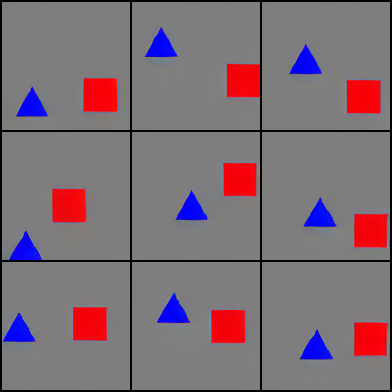

In [39]:
prompt_cache_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/prompt_cache_t5emb_20token"

ckpt_name = "epoch_4000_step_160000.pth"
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
with torch.no_grad():
    image_logs = visualize_prompts(pipeline, validation_prompts=None, prompt_cache_dir=prompt_cache_dir, max_length=20, weight_dtype=torch.float16,
                    num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=9, device="cuda")
pil_images_to_grid(image_logs[1]['images'])

/tmp/ipykernel_1341554/833668238.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, ckpt_name))
/tmp/ipykernel_1341554/2742891435.py:30: Fut

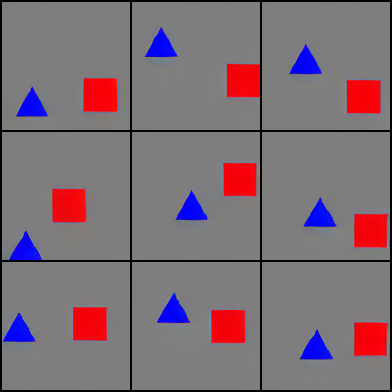

In [30]:
prompt_cache_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/prompt_cache_t5emb_20token"

ckpt_name = "epoch_4000_step_160000.pth"
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
with torch.no_grad():
    image_logs = visualize_prompts(pipeline, validation_prompts=None, prompt_cache_dir=prompt_cache_dir, max_length=20, weight_dtype=torch.float16,
                    num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=9, device="cuda")
pil_images_to_grid(image_logs[1]['images'])

/tmp/ipykernel_1341554/1837472526.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, ckpt_name))
/tmp/ipykernel_1341554/2742891435.py:30: Fu

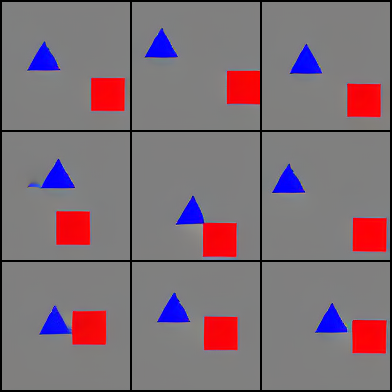

In [31]:
prompt_cache_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/prompt_cache_t5emb_20token"

ckpt_name = "epoch_4000_step_160000.pth"
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))
with torch.no_grad():
    image_logs = visualize_prompts(pipeline, validation_prompts=None, prompt_cache_dir=prompt_cache_dir, max_length=20, weight_dtype=torch.float16,
                    num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=9, device="cuda")
pil_images_to_grid(image_logs[1]['images'])

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.
/tmp/ipykernel_1341554/3652892915.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full

torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])


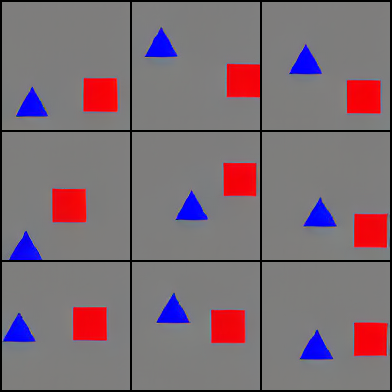

In [36]:
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)

ckpt_name = "epoch_4000_step_160000.pth"
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))

prompt_cache_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/prompt_cache_t5emb_20token"
ckpt_name = "epoch_4000_step_160000.pth"
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
with torch.no_grad():
    image_logs = visualize_prompts(pipeline, validation_prompts=None, prompt_cache_dir=prompt_cache_dir, max_length=20, weight_dtype=torch.float16,
                    num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=9, device="cuda")
pil_images_to_grid(image_logs[1]['images'])

/tmp/ipykernel_1341554/1837472526.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, ckpt_name))
/tmp/ipykernel_1341554/2742891435.py:30: Fu

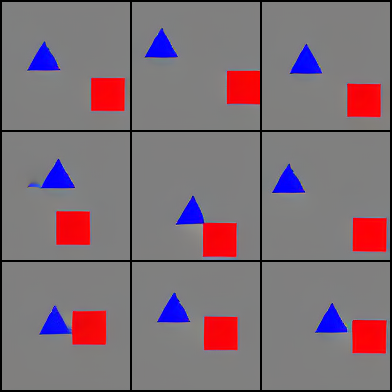

In [41]:
prompt_cache_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/prompt_cache_t5emb_20token"

ckpt_name = "epoch_4000_step_160000.pth"
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))
with torch.no_grad():
    image_logs = visualize_prompts(pipeline, validation_prompts=None, prompt_cache_dir=prompt_cache_dir, max_length=20, weight_dtype=torch.float16,
                    num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=9, device="cuda")
pil_images_to_grid(image_logs[1]['images'])

### Debug notes
* Generation with `visualize_prompt` still works perfectly
    * So the information is IN the state dict! The training run did not fail. 
    * Both `state_dict_ema` and `state_dict` works!! The results are not identical, but definitely both plausible. So it's not this difference causing it to crash. 
    * `torch.float16` as weight dtype is fine!
    * `PixArtTransformer2DModel` and `Transformer2DModel` are both fine and seems interchangeable, the generation results seem identitcal. so it's not their fault. 
    * `PixArtAlphaPipeline_custom` also works, basically identical as `PixArtAlphaPipeline` so it's not their fault. 
* The most likely culprit will be T5. 


### Main culprit is related to T5 and their embedding

In [43]:
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)

ckpt_name = "epoch_4000_step_160000.pth"
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))

T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")
text_encoder = T5EncoderModel.from_pretrained(T5_path, load_in_8bit=False, torch_dtype=torch.float16, )
pipeline.text_encoder = text_encoder
pipeline.tokenizer = tokenizer
pipeline.to(device="cuda", dtype=weight_dtype);

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.
/tmp/ipykernel_1341554/2475051111.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have ful

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [44]:
torch.cuda.empty_cache()

With no reliance on T5 this is totally fine

/tmp/ipykernel_1341554/2742891435.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  uncond_data = torch.load(f'{prompt_cache_dir}/uncond_{max_length}token.pth', map_locat

torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])
torch.Size([18, 20, 4096])
torch.Size([18, 20])


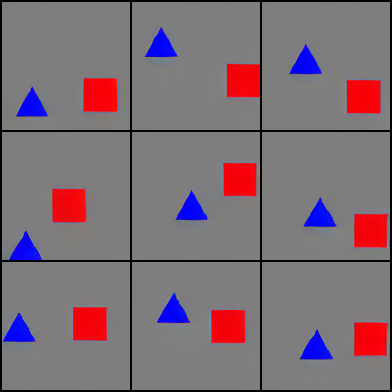

In [ ]:
with torch.no_grad():
    image_logs = visualize_prompts(pipeline, validation_prompts=None, prompt_cache_dir=prompt_cache_dir, max_length=20, weight_dtype=torch.float16,
                    num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=9, device="cuda")
pil_images_to_grid(image_logs[1]['images'])

When using T5 this is totally not

torch.Size([18, 20, 4096])
torch.Size([18, 20])


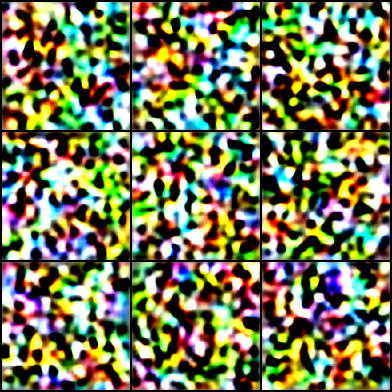

In [49]:
with torch.no_grad():
    out = pipeline("blue triangle is to the upper left of red square", num_inference_steps=14, max_sequence_length=20, num_images_per_prompt=9, return_sample_pred_traj=True, device="cuda")

grid = pil_images_to_grid(out[0].images)
grid

In [ ]:
!ls {prompt_cache_dir}

'blue circle is above and to the right of blue square_20token.pth'
'blue circle is above blue square_20token.pth'
'blue square is to the right of red circle_20token.pth'
'blue triangle is above red triangle_20token.pth'
'blue triangle is to the upper left of red square_20token.pth'
 caption_embeddings_list.pth
'circle is below red square_20token.pth'
'red circle is above square_20token.pth'
'red circle is to the left of blue square_20token.pth'
'red is above blue_20token.pth'
'red is to the left of red_20token.pth'
'triangle is above and to the right of square_20token.pth'
'triangle is above red circle_20token.pth'
'triangle is to the left of square_20token.pth'
'triangle is to the left of triangle_20token.pth'
'triangle is to the upper left of square_20token.pth'
 uncond_20token.pth


In [50]:
max_length = 20
device = "cuda"
prompt = "blue triangle is to the upper left of red square"
uncond_data = torch.load(f'{prompt_cache_dir}/uncond_{max_length}token.pth', map_location='cpu')
uncond_prompt_embeds = uncond_data['caption_embeds'].to(device)
uncond_prompt_attention_mask = uncond_data['emb_mask'].to(device)
visualized_prompts = []
if not os.path.exists(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth'):
    raise FileNotFoundError
embed = torch.load(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth', map_location='cpu')
caption_embs, emb_masks = embed['caption_embeds'].to(device), embed['emb_mask'].to(device)

/tmp/ipykernel_1341554/4166913348.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  uncond_data = torch.load(f'{prompt_cache_dir}/uncond_{max_length}token.pth', map_locati

torch.Size([18, 20, 4096])
torch.Size([18, 20])


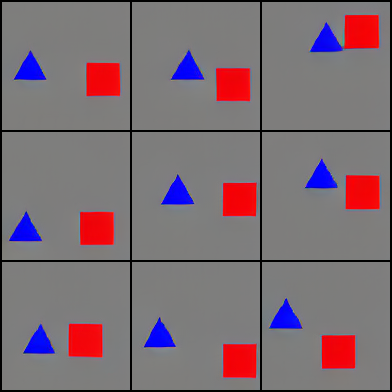

In [68]:
out = pipeline(prompt_embeds=caption_embs, prompt_attention_mask=emb_masks, 
               negative_prompt=None, negative_prompt_embeds=uncond_prompt_embeds, negative_prompt_attention_mask=uncond_prompt_attention_mask, 
         num_images_per_prompt=9, guidance_scale=4.5, num_inference_steps=14, max_sequence_length=20, device="cuda")
pil_images_to_grid(out.images)


### The key difference is how the embeddings are got there is huge divergence here!!

In [62]:
import inspect
print(inspect.getsource(pipeline.encode_prompt))

    def encode_prompt(
        self,
        prompt: Union[str, List[str]],
        do_classifier_free_guidance: bool = True,
        negative_prompt: str = "",
        num_images_per_prompt: int = 1,
        device: Optional[torch.device] = None,
        prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        prompt_attention_mask: Optional[torch.Tensor] = None,
        negative_prompt_attention_mask: Optional[torch.Tensor] = None,
        clean_caption: bool = False,
        max_sequence_length: int = 120,
        **kwargs,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt not to guide the image generation. If not defined, one has to pass `negative_prompt_embeds`
                instead. Ignored when

In [54]:
num_images_per_prompt = 1
negative_prompt = ""
clean_caption = True
max_sequence_length = 20
device = "cuda"
prompt = "blue triangle is to the upper left of red square"
prompt_embeds = None
negative_prompt_embeds = None
prompt_attention_mask = None
negative_prompt_attention_mask = None
with torch.no_grad():
    (
        prompt_embeds,
        prompt_attention_mask,
        negative_prompt_embeds,
        negative_prompt_attention_mask,
    ) = pipeline.encode_prompt(
        prompt,
        True,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_images_per_prompt,
        device=device,
        prompt_embeds=prompt_embeds,
        negative_prompt_embeds=negative_prompt_embeds,
        prompt_attention_mask=prompt_attention_mask,
        negative_prompt_attention_mask=negative_prompt_attention_mask,
        clean_caption=clean_caption,
        max_sequence_length=max_sequence_length,
    )

In [55]:
prompt_embeds

tensor([[[ 0.0889, -0.1068,  0.0714,  ...,  0.0378, -0.0616,  0.0153],
         [ 0.1263, -0.1747, -0.0778,  ..., -0.0161,  0.0191,  0.0112],
         [ 0.0393, -0.1132, -0.1151,  ..., -0.0543, -0.0618,  0.0327],
         ...,
         [ 0.1000, -0.0298, -0.1279,  ..., -0.0681,  0.0511,  0.1032],
         [ 0.0596, -0.0212, -0.0745,  ..., -0.0449,  0.0635,  0.2319],
         [ 0.0603, -0.0077, -0.0297,  ..., -0.0789,  0.1168,  0.1008]]],
       device='cuda:0', dtype=torch.float16)

In [51]:
caption_embs

tensor([[[-0.1040, -0.0189,  0.0903,  ...,  0.1396, -0.0791, -0.0635],
         [ 0.0322, -0.0037,  0.0140,  ...,  0.1216, -0.0312,  0.0398],
         [ 0.0393, -0.0352, -0.2217,  ...,  0.0483, -0.0757,  0.0081],
         ...,
         [ 0.4160,  0.0197, -0.1187,  ..., -0.0630, -0.0776,  0.1768],
         [ 0.1914,  0.2451, -0.2910,  ..., -0.0576, -0.0265,  0.1406],
         [ 0.1045,  0.2314, -0.2236,  ..., -0.1504, -0.1484,  0.1187]]],
       device='cuda:0', dtype=torch.bfloat16)

In [69]:
print(uncond_prompt_embeds)
print(negative_prompt_embeds)
print(caption_embs)
print(prompt_embeds)

tensor([[[-0.0059, -0.0105, -0.0017,  ..., -0.0063,  0.0064,  0.0035],
         [ 0.0253, -0.0457,  0.0129,  ...,  0.0369, -0.0238,  0.0115],
         [ 0.0253, -0.0457,  0.0129,  ...,  0.0369, -0.0238,  0.0115],
         ...,
         [ 0.0253, -0.0457,  0.0129,  ...,  0.0369, -0.0238,  0.0115],
         [ 0.0253, -0.0457,  0.0129,  ...,  0.0369, -0.0238,  0.0115],
         [ 0.0253, -0.0457,  0.0129,  ...,  0.0369, -0.0238,  0.0115]]],
       device='cuda:0', dtype=torch.bfloat16)
tensor([[[-0.0396,  0.0553, -0.0570,  ...,  0.0006,  0.0506,  0.0531],
         [-0.2905, -0.0047, -0.2295,  ...,  0.2253, -0.0351,  0.1486],
         [-0.2905, -0.0047, -0.2295,  ...,  0.2253, -0.0351,  0.1486],
         ...,
         [-0.2905, -0.0047, -0.2295,  ...,  0.2253, -0.0351,  0.1486],
         [-0.2905, -0.0047, -0.2295,  ...,  0.2253, -0.0351,  0.1486],
         [-0.2905, -0.0047, -0.2295,  ...,  0.2253, -0.0351,  0.1486]]],
       device='cuda:0', dtype=torch.float16)
tensor([[[-0.1040, -0.018

Cosine similarity: 0.432547
L2 distance: 32.474995
MSE: 0.012874
Are embeddings identical (within 1e-6): False


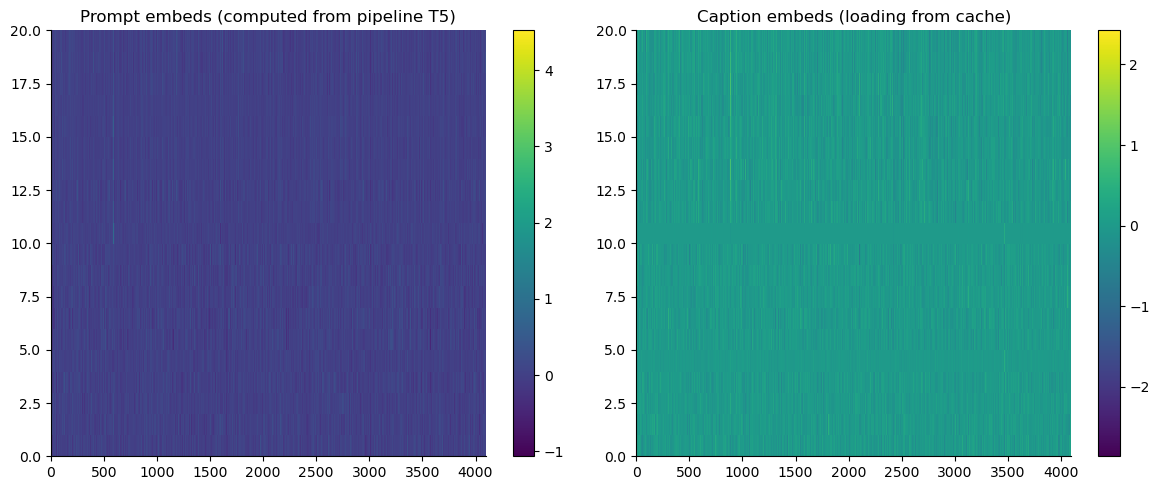

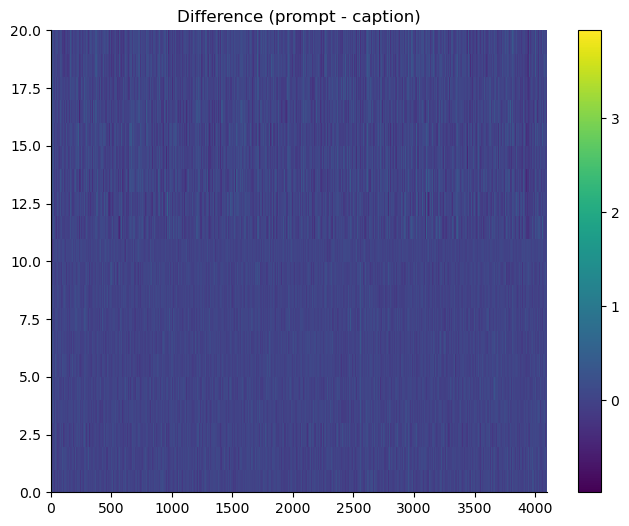

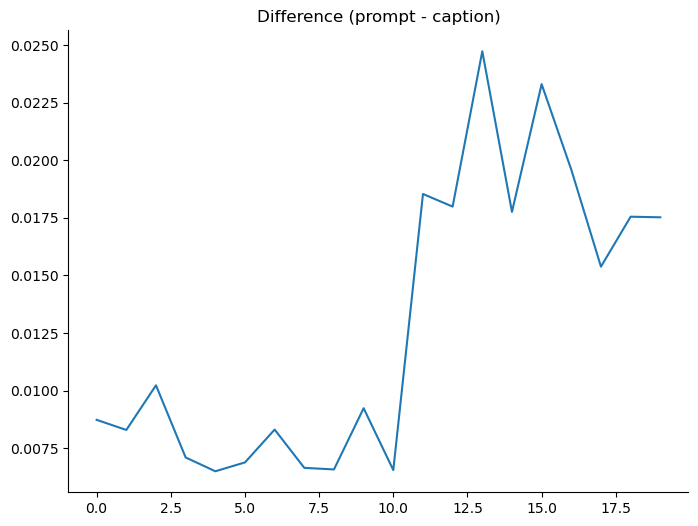

In [76]:
# Compare similarity between prompt_embeds and caption_embs
prompt_flat = prompt_embeds[0].cpu().float().flatten()
caption_flat = caption_embs[0].cpu().float().flatten()

# Cosine similarity
cosine_sim = torch.nn.functional.cosine_similarity(prompt_flat.unsqueeze(0), caption_flat.unsqueeze(0))
print(f"Cosine similarity: {cosine_sim.item():.6f}")

# L2 distance
l2_dist = torch.norm(prompt_flat - caption_flat).item()
print(f"L2 distance: {l2_dist:.6f}")

# Mean squared error
mse = torch.nn.functional.mse_loss(prompt_flat, caption_flat).item()
print(f"MSE: {mse:.6f}")

# Are they identical?
are_identical = torch.allclose(prompt_flat, caption_flat, atol=1e-6)
print(f"Are embeddings identical (within 1e-6): {are_identical}")

# Visualize the embeddings
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pcolor(prompt_embeds[0].cpu().float())
plt.title("Prompt embeds (computed from pipeline T5)")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolor(caption_embs[0].cpu().float())
plt.title("Caption embeds (loading from cache)")
plt.colorbar()
plt.tight_layout()
plt.show()

# Show difference heatmap
plt.figure(figsize=(8, 6))
diff = prompt_embeds[0].cpu().float() - caption_embs[0].cpu().float()
plt.pcolor(diff)
plt.title("Difference (prompt - caption)")
plt.colorbar()
plt.show()
# Show difference heatmap
plt.figure(figsize=(8, 6))
diff = prompt_embeds[0].cpu().float() - caption_embs[0].cpu().float()
plt.plot(diff.pow(2).mean(dim=1))
plt.title("Difference (prompt - caption)")
plt.show()

Cosine similarity: -0.000988
L2 distance: 37.315300
MSE: 0.016997
Are embeddings identical (within 1e-6): False


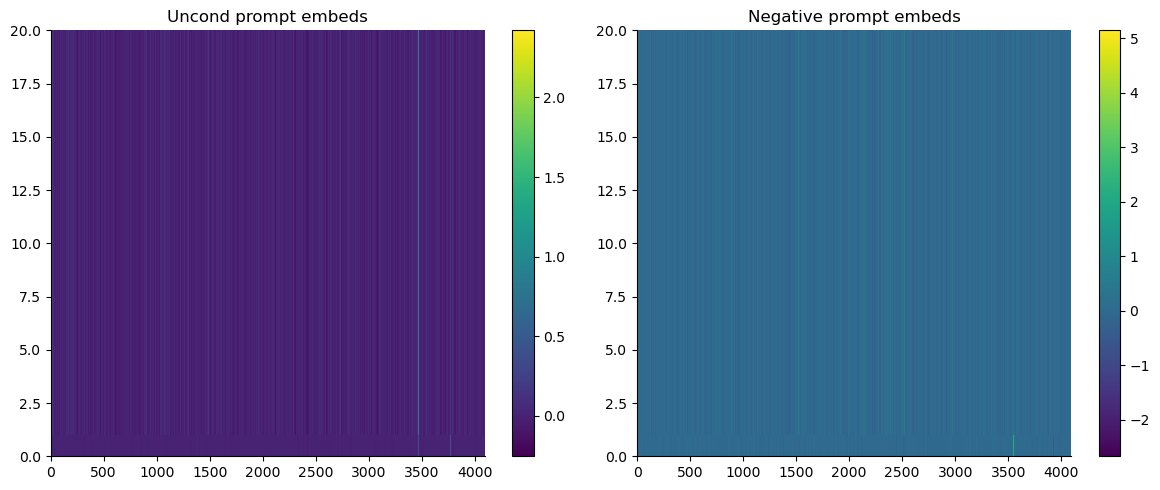

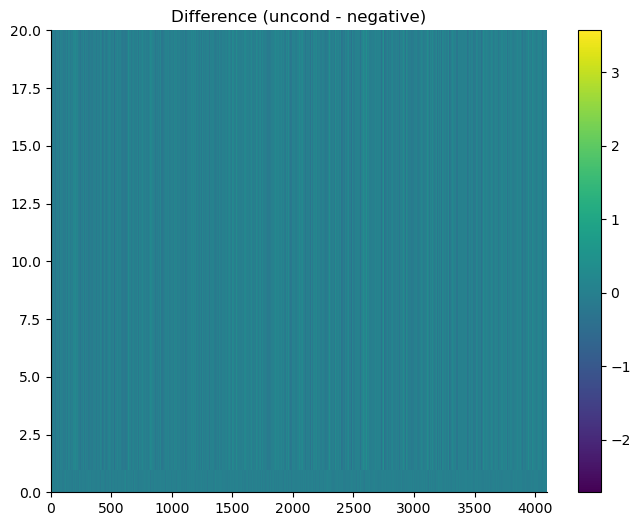

In [ ]:
# Compare similarity between uncond_prompt_embeds and negative_prompt_embeds
uncond_flat = uncond_prompt_embeds[0].cpu().float().flatten()
negative_flat = negative_prompt_embeds[0].cpu().float().flatten()

# Cosine similarity
cosine_sim = torch.nn.functional.cosine_similarity(uncond_flat.unsqueeze(0), negative_flat.unsqueeze(0))
print(f"Cosine similarity: {cosine_sim.item():.6f}")

# L2 distance
l2_dist = torch.norm(uncond_flat - negative_flat).item()
print(f"L2 distance: {l2_dist:.6f}")

# Mean squared error
mse = torch.nn.functional.mse_loss(uncond_flat, negative_flat).item()
print(f"MSE: {mse:.6f}")

# Are they identical?
are_identical = torch.allclose(uncond_flat, negative_flat, atol=1e-6)
print(f"Are embeddings identical (within 1e-6): {are_identical}")

# Visualize the embeddings
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pcolor(uncond_prompt_embeds[0].cpu().float())
plt.title("Uncond prompt embeds")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolor(negative_prompt_embeds[0].cpu().float())
plt.title("Negative prompt embeds")
plt.colorbar()
plt.tight_layout()
plt.show()

# Show difference heatmap
plt.figure(figsize=(8, 6))
diff = uncond_prompt_embeds[0].cpu().float() - negative_prompt_embeds[0].cpu().float()
plt.pcolor(diff)
plt.title("Difference (uncond - negative)")
plt.colorbar()
plt.show()

In [ ]:
negative_prompt_embeds

torch.Size([1, 20, 4096])

In [ ]:

T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")
text_encoder = T5EncoderModel.from_pretrained(T5_path, load_in_8bit=False, torch_dtype=torch.bfloat16, ) # bfloat16 is KEEYYYYEEYEYEYEYYEYEEYEYEYEY
pipeline.text_encoder = text_encoder.to(device="cuda", )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [83]:
num_images_per_prompt = 1
negative_prompt = ""
clean_caption = True
max_sequence_length = 20
device = "cuda"
prompt = "blue triangle is to the upper left of red square"
prompt_embeds = None
negative_prompt_embeds = None
prompt_attention_mask = None
negative_prompt_attention_mask = None
with torch.no_grad():
    (
        prompt_embeds,
        prompt_attention_mask,
        negative_prompt_embeds,
        negative_prompt_attention_mask,
    ) = pipeline.encode_prompt(
        prompt,
        True,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_images_per_prompt,
        device=device,
        prompt_embeds=prompt_embeds,
        negative_prompt_embeds=negative_prompt_embeds,
        prompt_attention_mask=prompt_attention_mask,
        negative_prompt_attention_mask=negative_prompt_attention_mask,
        clean_caption=clean_caption,
        max_sequence_length=max_sequence_length,
    )
assert torch.allclose(prompt_embeds, caption_embs, atol=1e-6)
assert torch.allclose(negative_prompt_embeds, uncond_prompt_embeds, atol=1e-6)

In [82]:
caption_embs

tensor([[[-0.1040, -0.0189,  0.0903,  ...,  0.1396, -0.0791, -0.0635],
         [ 0.0322, -0.0037,  0.0140,  ...,  0.1216, -0.0312,  0.0398],
         [ 0.0393, -0.0352, -0.2217,  ...,  0.0483, -0.0757,  0.0081],
         ...,
         [ 0.4160,  0.0197, -0.1187,  ..., -0.0630, -0.0776,  0.1768],
         [ 0.1914,  0.2451, -0.2910,  ..., -0.0576, -0.0265,  0.1406],
         [ 0.1045,  0.2314, -0.2236,  ..., -0.1504, -0.1484,  0.1187]]],
       device='cuda:0', dtype=torch.bfloat16)

In [84]:
prompt_embeds

tensor([[[-0.1040, -0.0189,  0.0903,  ...,  0.1396, -0.0791, -0.0635],
         [ 0.0322, -0.0037,  0.0140,  ...,  0.1216, -0.0312,  0.0398],
         [ 0.0393, -0.0352, -0.2217,  ...,  0.0483, -0.0757,  0.0081],
         ...,
         [ 0.4160,  0.0197, -0.1187,  ..., -0.0630, -0.0776,  0.1768],
         [ 0.1914,  0.2451, -0.2910,  ..., -0.0576, -0.0265,  0.1406],
         [ 0.1045,  0.2314, -0.2236,  ..., -0.1504, -0.1484,  0.1187]]],
       device='cuda:0', dtype=torch.bfloat16)

In [86]:
pipeline.to(dtype=torch.bfloat16)

PixArtAlphaPipeline_custom {
  "_class_name": "PixArtAlphaPipeline_custom",
  "_diffusers_version": "0.35.0.dev0",
  "_name_or_path": "PixArt-alpha/PixArt-XL-2-512x512",
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "tokenizer": [
    null,
    null
  ],
  "transformer": [
    "diffusers",
    "Transformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

torch.Size([18, 20, 4096])
torch.Size([18, 20])


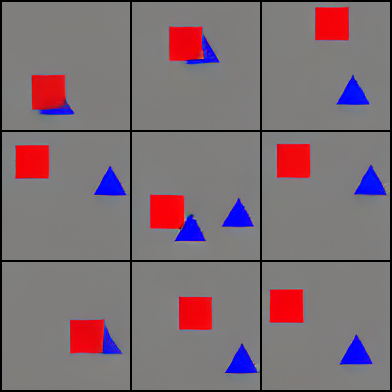

In [93]:
with torch.no_grad():
    out = pipeline("blue triangle is to the right of red square", 
                   num_inference_steps=14, max_sequence_length=20, num_images_per_prompt=9, seed=42,
                   return_sample_pred_traj=True, device="cuda")

grid = pil_images_to_grid(out[0].images)
grid

### Single Object dataset debug 

In [37]:
# model_run_name = "objrel_T5_DiT_mini_pilot" # "objrel_rndembdposemb_DiT_B_pilot" 
model_run_name = "objrel_singleobj_T5_DiT_B_pilot2" # "objrel_rndembdposemb_DiT_B_pilot" 
ckpt_name = "epoch_4000_step_160000.pth"  # "epoch_1500_step_60000.pth" # 
text_encoder_type = "T5" 
suffix = ""

from diffusers import PixArtTransformer2DModel
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}/cross_attn_vis_figs"
os.makedirs(figdir, exist_ok=True)

config = read_config(join(savedir, 'config.py'))
weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()
num_layers = len(model.blocks)
transformer = PixArtTransformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=tokenizer,
    text_encoder=None,
    torch_dtype=weight_dtype,
)
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
# pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
pipeline.tokenizer = tokenizer
pipeline.text_encoder = text_encoder
pipeline.to(device="cuda", dtype=weight_dtype);

# add attention map store hooks
pipeline.transformer = replace_attn_processor(pipeline.transformer)
attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
attnvis_store.setup_hooks()
torch.cuda.empty_cache()

2025-07-18 13:45:16,451 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_1327237/3395804470.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, ckpt_name))


Setting up hooks for PixArt attention modules:
- Block 0
- Block 1
- Block 2
- Block 3
- Block 4
- Block 5
- Block 6
- Block 7
- Block 8
- Block 9
- Block 10
- Block 11


In [45]:

text_feat_dir_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndemb/caption_feature_wmask'
T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")
if text_encoder_type == "T5":
    text_encoder = T5EncoderModel.from_pretrained(T5_path, load_in_8bit=False, torch_dtype=torch.bfloat16, )
elif text_encoder_type == "RandomEmbeddingEncoder_wPosEmb":
    emb_data = th.load(join(text_feat_dir_old, "word_embedding_dict.pt"))
    text_encoder = RandomEmbeddingEncoder_wPosEmb(emb_data["embedding_dict"], 
                                                emb_data["input_ids2dict_ids"], 
                                                emb_data["dict_ids2input_ids"], 
                                                max_seq_len=20, embed_dim=4096,
                                                wpe_scale=1/6).to("cuda")
torch.cuda.empty_cache()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [48]:
pipeline.text_encoder = text_encoder
pipeline.to(device="cuda", dtype=weight_dtype);

/tmp/ipykernel_1327237/3009982201.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, ckpt_name))


torch.Size([18, 20, 4096])
torch.Size([18, 20])


  0%|          | 0/14 [00:00<?, ?it/s]

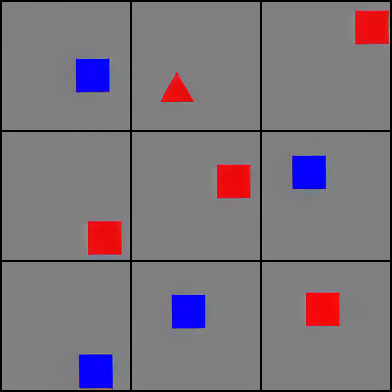

In [61]:
ckpt_name = "epoch_2000_step_80000.pth"
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))
prompt = "a blue square"
n_samples = 9
attnvis_store.clear_activation()
output = pipeline(prompt, 
        num_inference_steps=14,
            max_sequence_length=20, 
            num_images_per_prompt=n_samples,
            guidance_scale=2.0,
            return_sample_pred_traj=True,
            device="cuda")
pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
grid = pil_images_to_grid(output[0].images)
grid